MovieLens 100K dataset을 바탕으로 추천 시스템을 설계하고 성능 비교

### Data Load

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='whitegrid')


In [170]:
# 사용자 정보
user_cols = ['User_ID', 'Age', 'Sex', 'Occupation', 'ZIP_Code']
users = pd.read_csv('data/ml-100k/u.user', sep='|', names=user_cols, encoding='latin-1')

# 평점 정보
rating_cols = ['User_ID', 'Movie_ID', 'Rating', 'Timestamp']
ratings = pd.read_csv('data/ml-100k/u.data', sep='\t', names=rating_cols, encoding='latin-1')

# 영화 정보
movie_cols = ['Movie_ID', 'Title', 'Release_Date', 'Video_Release_Date', 'IMDB_URL']
movies = pd.read_csv('data/ml-100k/u.item', sep='|', names=movie_cols, usecols=range(5), encoding='latin-1')

nb_users = users['User_ID'].nunique()
nb_movies = ratings['Movie_ID'].nunique()
print(f"유저 수: {nb_users}, 영화 수: {nb_movies}")

유저 수: 943, 영화 수: 1682


### Data Analysis
`ratings`는 추천의 핵심 정보 (누가 어떤 영화를 몇 점 줬는지)  

`users`는 평점을 준 사람에 대한 정보들이 들어가 있음  

이 둘의 관계를 파악해서 어떤 users들의 정보와 rating을 기반으로 영화 추천 모델을 설계

In [171]:
users

,User_ID,Age,Sex,Occupation,ZIP_Code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [172]:
ratings

,User_ID,Movie_ID,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [173]:
movies

,Movie_ID,Title,Release_Date,Video_Release_Date,IMDB_URL
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)
...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998)
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...


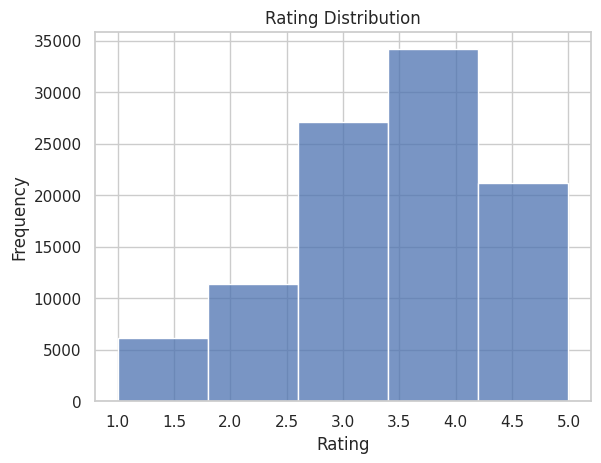

In [174]:
# 평점 분포 확인
sns.histplot(ratings['Rating'], bins=5, kde=False)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

MovieLens 100K는 943명의 사용자, 1682개의 영화에 대한 100,000개의 평점으로 구성.

현재 추천 model을 설계하기 위해선, `User_ID`가 어떤 `Movie_ID`에 얼만큼의 `Rating` 을 주었는지에 대한 관계를 이해해야 함.

그렇기에, `User_ID`, `Movie_ID`, `Rating` 에 대한 utils matrix (user-movie 간 행렬)을 구성

### Data Preprocessing

>추천 시스템의 핵심은 누가 무엇을 얼마나 선호했는가를 파악하는 것
>
>이를 위해 필요한 것은 사용자의 평점 데이터(`ratings`)이며, 이 데이터를 `행렬 형태로 재구성`해야 이후 알고리즘이 작동
>
>그렇기에, 학습을 하기 전에 전처리 과정에서 `User_ID`, `Movie_ID`, `Rating` 에 대한 utils matrix (user-movie 간 행렬)을 구성

In [175]:
# 사용자-영화 평점 행렬 생성 (utility matrix)
ratings_matrix = ratings.pivot(
    index='User_ID', columns='Movie_ID', values='Rating'
)
data_matrix = ratings_matrix.values 
print(f"사용자-영화 평점 행렬: {data_matrix.shape}")
data_matrix

사용자-영화 평점 행렬: (943, 1682)


array([[ 5.,  3.,  4., ..., nan, nan, nan],
       [ 4., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 5., nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan,  5., nan, ..., nan, nan, nan]])

In [176]:
total_possible = ratings_matrix.shape[0] * ratings_matrix.shape[1]
actual_rated = ratings_matrix.count().sum()
sparsity = 1 - actual_rated / total_possible
print(f"Sparsity Rate: {sparsity:.4f} (전체의 {sparsity*100:.2f}% 가 비어있음)")

Sparsity Rate: 0.9370 (전체의 93.70% 가 비어있음)


NaN(평점 없음)을 0으로 대체

### Utility Matrix (사용자-영화 간 행렬)

In [177]:
ratings_matrix.fillna(0, inplace=True)
ratings_matrix

Movie_ID,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
User_ID,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


user의 수 : 943 명 , movie의 수  : 1682 편에 맞게 잘 형성됨.


#### 성능 평가를 위해 dataset 분리

In [178]:
from sklearn.model_selection import train_test_split

# 1) ratings를 train/test로 분리
train_ratings, test_ratings = train_test_split(
    ratings, test_size=0.2, random_state=42
)

all_movies = movies['Movie_ID'].unique()
all_users = ratings['User_ID'].unique()


train_matrix = train_ratings.pivot_table(index='User_ID', columns='Movie_ID', values='Rating', fill_value=0) \
                             .reindex(index=all_users, columns=all_movies, fill_value=0)


test_matrix = test_ratings.pivot(index='User_ID', columns='Movie_ID', values='Rating') \
                           .reindex(index=all_users, columns=all_movies)



In [179]:
train_matrix

Movie_ID,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
User_ID,,,,,,,,,,,,,,,,,,,,,
196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
186,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,2.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244,4.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
936,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
930,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [180]:
test_matrix

Movie_ID,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
User_ID,,,,,,,,,,,,,,,,,,,,,
196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
166,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
936,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Recommender Systems (추천 시스템)

### Collaborative filtering
협업 필터링 기반 추천 (User-User, Item-Item)

협업 필터링은 '나와 비슷한 사용자가 좋아한 영화를 추천해주는 방식'

- `User-Based CF`: 나와 취향이 비슷한 사람들을 찾은 후, 그들이 좋아한 아이템을 추천
- `Item-Based CF`: 내가 좋아한 아이템과 유사한 아이템을 추천


In [181]:
### 코사인 유사도 기반 유사도 행렬
from sklearn.metrics.pairwise import cosine_similarity

user_similarity = cosine_similarity(train_matrix)
item_similarity = cosine_similarity(train_matrix.T)

In [182]:
user_sim_df = pd.DataFrame(user_similarity, 
                           index=train_matrix.index, 
                           columns=train_matrix.index)
user_sim_df


User_ID,196,186,22,244,166,298,115,253,305,6,...,925,942,937,926,943,939,936,930,920,941
User_ID,,,,,,,,,,,,,,,,,,,,,
196,1.000000,0.027102,0.131413,0.157253,0.016625,0.086014,0.031451,0.068406,0.153548,0.118667,...,0.000000,0.008571,0.184986,0.116712,0.084665,0.079718,0.181432,0.149910,0.070828,0.044891
186,0.027102,1.000000,0.093251,0.094177,0.040754,0.117140,0.126458,0.216130,0.090949,0.091950,...,0.122510,0.104081,0.050712,0.081957,0.192170,0.156228,0.117891,0.102078,0.065767,0.160482
22,0.131413,0.093251,1.000000,0.155401,0.012943,0.247128,0.132422,0.197806,0.174281,0.169524,...,0.000000,0.051634,0.004008,0.006085,0.300141,0.060549,0.051435,0.120816,0.000000,0.045246
244,0.157253,0.094177,0.155401,1.000000,0.025325,0.215642,0.132890,0.187561,0.255523,0.224394,...,0.034257,0.160481,0.076850,0.027779,0.287490,0.068861,0.144959,0.169610,0.042911,0.066245
166,0.016625,0.040754,0.012943,0.025325,1.000000,0.020759,0.000000,0.106066,0.064665,0.013674,...,0.085888,0.177578,0.138082,0.316885,0.000000,0.000000,0.061817,0.066793,0.240986,0.120009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.079718,0.156228,0.060549,0.068861,0.000000,0.135396,0.046825,0.181791,0.057543,0.067966,...,0.000000,0.022331,0.197169,0.000000,0.130515,1.000000,0.182595,0.066229,0.000000,0.155705
936,0.181432,0.117891,0.051435,0.144959,0.061817,0.103647,0.129226,0.111524,0.145392,0.151176,...,0.125586,0.074227,0.262261,0.158218,0.126686,0.182595,1.000000,0.265137,0.173424,0.199287
930,0.149910,0.102078,0.120816,0.169610,0.066793,0.119990,0.128190,0.175651,0.221369,0.157251,...,0.000000,0.078602,0.188842,0.047782,0.111945,0.066229,0.265137,1.000000,0.042177,0.173984


Utils matrix와 transpose utils matrix 곱을 해보면 1행 1열은 user1, user1 간의 similarity, 1행 2열은 user1, user2 간의 similarity  
`사용자간 유사도가 matrix`로 표현되는 것

In [183]:
item_sim_df = pd.DataFrame(item_similarity, 
                           index=train_matrix.columns, 
                           columns=train_matrix.columns)
item_sim_df

Movie_ID,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
Movie_ID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.311393,0.253690,0.350312,0.214229,0.081377,0.520601,0.376806,0.395321,0.208464,...,0.040426,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.311393,1.000000,0.216764,0.383544,0.304612,0.000000,0.297186,0.308952,0.222845,0.121722,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.088312,0.0
3,0.253690,0.216764,1.000000,0.261066,0.141570,0.058716,0.271301,0.167238,0.224092,0.120622,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.350312,0.383544,0.261066,1.000000,0.270286,0.061803,0.366117,0.370546,0.265128,0.190169,...,0.000000,0.0,0.0,0.103406,0.0,0.0,0.0,0.0,0.062044,0.0
5,0.214229,0.304612,0.141570,0.270286,1.000000,0.017833,0.246926,0.196619,0.199997,0.036237,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,1.0,1.0,1.0,0.000000,0.0
1679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,1.0,1.0,1.0,0.000000,0.0
1680,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,1.0,1.0,1.0,0.000000,0.0


Transpose Utils matrix와 utils matrix 곱을 해보면 1행 1열은 movie1, movie1 간의 similarity, 1행 2열은 movie1, movie2 간의 similarity  
`영화간 유사도를 통한 추천 시스템`로 표현되는 것

user_similarity : 사용자-사용자 간 유사도   (943 x 943) 

item_similarity : 영화-영화 간 유사도  (1682 x 1682)

ratings_matrix  : 실제 사용자-영화 평점 매트릭스 (943 x 1682)


In [184]:
### 예측 함수 정의 (user-based)
def predict_user_based(ratings, similarity):
    mean_user_rating = ratings.mean(axis=1).reshape(-1, 1)
    ratings_diff = ratings - mean_user_rating
    pred = mean_user_rating + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    return pred

### 예측 함수 정의 (item-based)
def predict_item_based(ratings, similarity):
    pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

### 예측
user_pred_cf = predict_user_based(train_matrix.values, user_similarity)
item_pred_cf = predict_item_based(train_matrix.values, item_similarity)

# 유틸리티 행렬 복구 (user_id, movie_id 인덱스를 기준으로)
user_ids = train_matrix.index
movie_ids = train_matrix.columns

# 예측 결과를 데이터프레임으로 변환
user_pred_cf_df = pd.DataFrame(user_pred_cf, index=user_ids, columns=movie_ids)
item_pred_cf_df = pd.DataFrame(item_pred_cf, index=user_ids, columns=movie_ids)

/tmp/ipykernel_3478127/4283451805.py:10: RuntimeWarning: invalid value encountered in divide
  pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])


[ratings_matrix]x[item_similarity]=[item_pred_cf_df] 이렇게 행렬곱으로 계산

In [185]:
user_pred_cf_df

Movie_ID,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
User_ID,,,,,,,,,,,,,,,,,,,,,
196,1.412270,0.240210,0.142475,0.714153,0.118990,-0.046419,1.236058,0.763348,1.010673,0.241401,...,-0.150750,-0.153947,-0.153947,-0.151692,-0.153947,-0.152577,-0.149837,-0.151207,-0.149576,-0.153947
186,1.623399,0.469734,0.232492,0.786876,0.298777,-0.025224,1.504041,0.746665,1.036119,0.209155,...,-0.077855,-0.079819,-0.079819,-0.075652,-0.079819,-0.078744,-0.076593,-0.077668,-0.075072,-0.079819
22,1.819999,0.672080,0.265839,1.213357,0.320866,-0.006751,1.681039,1.085066,1.035443,0.309788,...,-0.069864,-0.072937,-0.072937,-0.070418,-0.072937,-0.072910,-0.072857,-0.072883,-0.064790,-0.072937
244,2.125270,0.760693,0.553585,1.241384,0.533307,0.239365,1.991955,1.271706,1.504667,0.552555,...,0.162038,0.157281,0.157281,0.160358,0.157281,0.157511,0.157971,0.157741,0.163668,0.157281
166,0.929802,0.109590,0.065772,0.269981,0.059581,-0.066746,0.811146,0.290627,0.590012,0.075126,...,-0.095770,-0.096409,-0.096409,-0.093512,-0.096409,-0.093738,-0.088396,-0.091067,-0.094345,-0.096409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,1.753006,0.282495,0.208538,0.551066,0.180948,-0.044610,1.483335,0.628024,1.435261,0.220246,...,-0.105686,-0.109535,-0.109535,-0.104458,-0.109535,-0.109184,-0.108482,-0.108833,-0.105351,-0.109535
936,1.745096,0.391833,0.423335,0.669685,0.307150,0.202853,1.575931,0.750658,1.387130,0.451330,...,0.082042,0.078876,0.078876,0.081712,0.078876,0.080186,0.082807,0.081497,0.081610,0.078876
930,1.804643,0.308787,0.203523,0.666330,0.151396,-0.027622,1.471222,0.802494,1.106275,0.253727,...,-0.111837,-0.114409,-0.114409,-0.112765,-0.114409,-0.114024,-0.113253,-0.113639,-0.109937,-0.114409


`User-Based CF`: 나와 취향이 비슷한 사람들을 찾은 후, 그들이 좋아한 아이템을 추천

In [186]:
item_pred_cf_df

Movie_ID,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
User_ID,,,,,,,,,,,,,,,,,,,,,
196,0.126765,0.095263,0.119490,0.114305,0.097719,0.117867,0.120051,0.118240,0.126812,0.116509,...,0.149953,NaN,NaN,0.074545,NaN,0.091250,0.091250,0.091250,0.089110,NaN
186,0.268814,0.258111,0.241054,0.236257,0.265082,0.111886,0.260569,0.213304,0.242024,0.173160,...,0.131908,NaN,NaN,0.349044,NaN,0.177587,0.177587,0.177587,0.190408,NaN
22,0.430890,0.471379,0.384285,0.465621,0.377266,0.214174,0.421391,0.401844,0.357613,0.332427,...,0.321654,NaN,NaN,0.272119,NaN,0.003703,0.003703,0.003703,0.457460,NaN
244,0.847729,0.748562,0.892598,0.788768,0.707014,0.485898,0.833545,0.755604,0.810667,0.647167,...,1.160811,NaN,NaN,0.601776,NaN,0.104108,0.104108,0.104108,0.653599,NaN
166,0.054805,0.038097,0.042101,0.037097,0.039692,0.024983,0.051385,0.037443,0.048967,0.037883,...,0.018116,NaN,NaN,0.112496,NaN,0.145086,0.145086,0.145086,0.028885,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.177853,0.123677,0.150052,0.116711,0.138096,0.084931,0.160581,0.123245,0.185895,0.104647,...,0.183754,NaN,NaN,0.305988,NaN,0.037115,0.037115,0.037115,0.103213,NaN
936,0.440518,0.270328,0.521823,0.299676,0.291698,0.668105,0.434735,0.330706,0.474913,0.404934,...,0.512064,NaN,NaN,0.410329,NaN,0.322428,0.322428,0.322428,0.194704,NaN
930,0.220205,0.149901,0.188626,0.163281,0.145494,0.157388,0.198426,0.180755,0.202053,0.169273,...,0.173402,NaN,NaN,0.090177,NaN,0.031608,0.031608,0.031608,0.135510,NaN


`Item-Based CF`: 내가 좋아한 아이템과 유사한 아이템을 추천

### Matrix Factorization (행렬 분해)
>협업 필터링의 한계는 sparsity.  
>
>대부분의 유틸리티 행렬은 비어 있고, 유사도를 계산할 수 없을 만큼 데이터가 적은 경우가 많음.  
>
>이를 해결하기 위해 matrix decomposition을 사용
- `Truncated SVD`: 모든 singularvalues를 다 사용하지 않고 일부만 사용해 표현해서 구현
- `ALS`: 내가 좋아한 아이템과 "유사한 아이템을 추천


### `The rank k Truncated SVD`

In [187]:
from scipy.sparse.linalg import svds

# 사용자 평균 평점으로 중심화
user_mean = train_matrix.values.mean(axis=1).reshape(-1, 1)
R_demeaned = train_matrix.values - user_mean

# SVD 분해 (k = 50 latent features)
U, sigma, Vt = svds(R_demeaned, k=50)
sigma = np.diag(sigma)

# 다시 원래 scale로 복구
svd_preds = np.dot(np.dot(U, sigma), Vt) + user_mean
svd_preds_df = pd.DataFrame(svd_preds, index=train_matrix.index, columns=train_matrix.columns)


In [188]:
svd_preds_df

Movie_ID,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
User_ID,,,,,,,,,,,,,,,,,,,,,
196,0.643146,-0.264930,0.171382,0.621089,0.055614,0.155993,0.183138,-0.162070,-0.315591,0.265176,...,-0.017919,-0.015497,-0.015497,-0.020938,-0.015497,-0.014091,-0.011281,-0.012686,-0.011297,-0.015497
186,0.179248,0.620963,-0.147405,1.041789,0.962143,-0.035078,0.373899,0.067759,0.238865,0.034585,...,-0.010676,0.011852,0.011852,0.022719,0.011852,0.012982,0.015242,0.014112,-0.003346,0.011852
22,0.121192,1.439365,0.209620,2.716795,0.126532,0.168507,-0.566324,0.633231,-1.487145,0.344558,...,-0.027907,-0.009923,-0.009923,-0.015528,-0.009923,-0.012369,-0.017259,-0.014814,0.016400,-0.009923
244,3.729101,0.191371,1.958994,1.179961,-0.430626,0.335484,5.129977,1.971330,5.061375,-0.135352,...,0.092301,0.046557,0.046557,0.084139,0.046557,0.044455,0.040249,0.042352,0.056214,0.046557
166,0.161893,-0.148019,-0.001768,-0.005792,-0.038370,-0.058057,-0.125540,-0.063702,-0.188989,-0.035535,...,-0.013712,-0.007148,-0.007148,-0.011872,-0.007148,-0.003123,0.004927,0.000902,-0.008876,-0.007148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.423866,0.120106,-0.140857,0.088773,0.678915,0.043436,0.196200,1.020927,3.238645,-0.299010,...,0.037684,0.023992,0.023992,0.046615,0.023992,0.018343,0.007045,0.012694,0.019865,0.023992
936,2.490567,-0.320211,1.430972,-0.702094,-0.194688,0.758827,1.557414,0.931528,3.285738,1.679822,...,0.140375,0.103194,0.103194,0.117182,0.103194,0.109525,0.122187,0.115856,0.078724,0.103194
930,2.370304,-0.024589,0.309710,0.357591,-0.099601,0.188445,0.563212,0.151863,-0.146991,0.323708,...,0.011793,0.011903,0.011903,0.002309,0.011903,0.010272,0.007010,0.008641,0.003455,0.011903


### `Alternating Least Squares`
ALS는 SVD와 달리 명시적으로 사용자-아이템(movie) 행렬을 두 개의 잠재 행렬로 나눠서 학습하는 방식
사용자 행렬 𝑈, 𝑉 를 반복적으로 번갈아가며 갱신하면서 전체 행렬을 근사

In [189]:
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix

# implicit 라이브러리는 implicit feedback 기반이기 때문에 평점을 confidence로 처리
# 일반적인 평점은 다음처럼 변환 가능: confidence = 1 + alpha * rating
alpha = 40
implicit_data = (csr_matrix(train_matrix.values) * alpha).astype('double')

# ALS 모델 정의 및 학습
als_model = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=20, use_gpu=False)
als_model.fit(implicit_data.T)



/home/icl/anaconda3/envs/ML/lib/python3.10/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.0005943775177001953 seconds
  warnings.warn(
  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 88.46it/s]


In [190]:
# ALS 모델의 user_factors와 item_factors를 numpy 배열로 변환
user_factors = als_model.user_factors
item_factors = als_model.item_factors

# 사용자-아이템 평점 예측
als_preds = item_factors @ user_factors.T


# 예측 결과를 DataFrame으로 변환
als_preds_df = pd.DataFrame(als_preds * 5, index=train_matrix.index, columns=train_matrix.columns)

als_preds_df

Movie_ID,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
User_ID,,,,,,,,,,,,,,,,,,,,,
196,3.723461,0.050235,1.582874,3.551535,-0.349827,2.467822,3.487315,4.120916,4.144297,-0.037372,...,0.420541,0.0,0.0,0.530098,0.0,0.133974,0.175678,0.162787,-0.850312,0.0
186,4.413437,4.839155,0.437731,3.995264,2.785479,0.658880,4.501138,4.109836,3.272989,2.015373,...,-0.311631,0.0,0.0,0.288015,0.0,0.198114,0.259545,0.240490,-1.467877,0.0
22,4.780057,4.469248,3.092879,4.895477,-0.981578,1.914153,4.987549,4.717034,3.611323,0.658100,...,-0.028089,0.0,0.0,0.222896,0.0,0.151031,0.196479,0.182417,0.446078,0.0
244,4.965691,4.044948,4.871054,4.669580,4.469380,1.628221,4.968308,4.729047,4.806179,4.061502,...,1.299113,0.0,0.0,0.460846,0.0,-0.385202,-0.508004,-0.470676,-0.795464,0.0
166,1.913217,-0.223117,0.014768,0.163616,0.209179,-0.447076,1.924811,-0.163115,1.873584,-1.688550,...,0.557160,0.0,0.0,-0.180017,0.0,-0.205069,-0.266863,-0.248377,0.526729,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,4.676169,-0.747199,-0.517952,-0.018627,0.394349,-0.894297,4.713112,0.145514,4.931839,1.723887,...,1.449972,0.0,0.0,0.649920,0.0,0.056626,0.073047,0.068121,0.204116,0.0
936,5.092936,0.164874,5.178098,-0.563579,0.183608,5.012279,5.288539,-0.082199,4.933482,6.612558,...,0.540420,0.0,0.0,1.419434,0.0,0.230460,0.303911,0.281696,0.395330,0.0
930,4.994816,1.823186,4.368223,4.075203,0.229909,-0.100591,4.984455,4.953240,4.859021,-0.195096,...,-0.217460,0.0,0.0,-0.622082,0.0,-0.155178,-0.207758,-0.191909,-0.053113,0.0


### 딥러닝 기반 모델
### `Autoencoder`

In [191]:
## 딥러닝 기반 Autoencoder 추천 시스템
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

nb_users, nb_movies = train_matrix.shape

data_matrix_torch = torch.FloatTensor(train_matrix.values)

class SAE(nn.Module):
    def __init__(self):
        super(SAE, self).__init__()
        self.fc1 = nn.Linear(nb_movies, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 64)
        self.fc4 = nn.Linear(64, nb_movies)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

sae = SAE()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(sae.parameters(), lr=0.01, weight_decay=0.5)

In [192]:
nb_epoch = 10
for epoch in range(1, nb_epoch+1):
    train_loss = 0
    s = 0
    for id_user in range(nb_users):
        input = Variable(data_matrix_torch[id_user]).unsqueeze(0)
        target = input.clone()
        if torch.sum(target.data > 0) > 0:
            output = sae(input)
            output[target == 0] = 0
            loss = criterion(output, target)
            loss.backward()
            train_loss += np.sqrt(loss.item())
            s += 1
            optimizer.step()
            optimizer.zero_grad()
    print(f"epoch: {epoch} loss: {train_loss/s:.4f}")

predict_sae = np.zeros((nb_users, nb_movies))
for id_user in range(nb_users):
    input = Variable(data_matrix_torch[id_user]).unsqueeze(0)
    predict_sae[id_user] = sae(input).detach().numpy()

sae_preds_df = pd.DataFrame(predict_sae * 5, index=train_matrix.index, columns=train_matrix.columns)


epoch: 1 loss: 0.7539
epoch: 2 loss: 0.7540
epoch: 3 loss: 0.7541
epoch: 4 loss: 0.7541
epoch: 5 loss: 0.7541
epoch: 6 loss: 0.7540
epoch: 7 loss: 0.7541
epoch: 8 loss: 0.7541
epoch: 9 loss: 0.7541
epoch: 10 loss: 0.7540


In [193]:
predict_sae = np.zeros((nb_users, nb_movies))
for id_user in range(nb_users):
    input = Variable(data_matrix_torch[id_user]).unsqueeze(0)
    predict_sae[id_user] = sae(input).detach().numpy()

sae_preds_df = pd.DataFrame(predict_sae * 5, index=train_matrix.index, columns=train_matrix.columns)

In [194]:
sae_preds_df

Movie_ID,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
User_ID,,,,,,,,,,,,,,,,,,,,,
196,1.655103,-1.116867,-1.098470,-0.153953,-0.673933,-1.134252,0.086370,0.854169,-0.403492,0.208484,...,-1.259706,0.037973,0.026854,-0.046646,0.025914,0.303787,-0.720798,0.540863,-0.448228,0.052805
186,1.655949,-1.117459,-1.099046,-0.154036,-0.674294,-1.134847,0.086417,0.854621,-0.403708,0.208596,...,-1.260374,0.037980,0.026882,-0.046658,0.025928,0.303931,-0.721173,0.541166,-0.448448,0.052848
22,1.656788,-1.118046,-1.099616,-0.154118,-0.674652,-1.135437,0.086463,0.855069,-0.403922,0.208707,...,-1.261036,0.037987,0.026910,-0.046670,0.025942,0.304073,-0.721544,0.541467,-0.448667,0.052890
244,1.658049,-1.118928,-1.100472,-0.154241,-0.675189,-1.136323,0.086532,0.855742,-0.404243,0.208874,...,-1.262030,0.037998,0.026951,-0.046688,0.025962,0.304287,-0.722101,0.541918,-0.448996,0.052953
166,1.654689,-1.116577,-1.098189,-0.153913,-0.673757,-1.133962,0.086347,0.853949,-0.403387,0.208429,...,-1.259380,0.037970,0.026840,-0.046640,0.025908,0.303717,-0.720616,0.540716,-0.448120,0.052785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,1.655350,-1.117040,-1.098639,-0.153977,-0.674039,-1.134426,0.086384,0.854302,-0.403555,0.208516,...,-1.259902,0.037975,0.026862,-0.046650,0.025918,0.303829,-0.720908,0.540952,-0.448292,0.052818
936,1.656737,-1.118010,-1.099580,-0.154113,-0.674630,-1.135400,0.086460,0.855042,-0.403909,0.208700,...,-1.260995,0.037987,0.026908,-0.046670,0.025941,0.304064,-0.721521,0.541448,-0.448654,0.052887
930,1.655647,-1.117247,-1.098840,-0.154006,-0.674165,-1.134634,0.086400,0.854460,-0.403631,0.208556,...,-1.260135,0.037978,0.026872,-0.046654,0.025923,0.303880,-0.721039,0.541058,-0.448369,0.052833


### Evaluate Metrics
`RMSE`, `Precision@10`

In [197]:
import numpy as np

def discretize(pred, low=1, high=5):
    """
    pred: (n_users, n_items) 실수 예측 행렬
    반환: 1~5 사이 정수로 반올림·클리핑한 np.int 배열
    """
    rounded = np.rint(pred)                  # 소수점 첫째자리에서 반올림
    clipped = np.clip(rounded, low, high)    # 1~5 벗어나는 값 방지
    return clipped.astype(int)


# 기존 float 예측 결과
user_pred = user_pred_cf_df.values
item_pred = item_pred_cf_df.values
svd_pred  = svd_preds_df.values
als_pred  = als_preds_scaled       # ALS는 이미 *5 해 둔 상태
sae_pred  = sae_preds_df.values

# 모두 정수로 반올림·클리핑
user_pred_int = discretize(user_pred)
item_pred_int = discretize(item_pred)
svd_pred_int  = discretize(svd_pred)
als_pred_int  = discretize(als_pred)
sae_pred_int  = discretize(sae_pred)


/tmp/ipykernel_3478127/1000005241.py:10: RuntimeWarning: invalid value encountered in cast
  return clipped.astype(int)


In [198]:
# true_matrix 는 test_matrix.values
print("RMSE (정수 예측)")
print(f"User-Based CF : {get_rmse(user_pred_int, true_matrix):.4f}")
print(f"Item-Based CF : {get_rmse(item_pred_int, true_matrix):.4f}")
print(f"SVD           : {get_rmse(svd_pred_int,  true_matrix):.4f}")
print(f"ALS           : {get_rmse(als_pred_int,  true_matrix):.4f}")
print(f"AutoEncoder   : {get_rmse(sae_pred_int,  true_matrix):.4f}")

print("Precision@10 (정수 예측)")
print(f"User-Based CF : {precision_at_k(user_pred_int, true_matrix):.4f}")
print(f"Item-Based CF : {precision_at_k(item_pred_int, true_matrix):.4f}")
print(f"SVD           : {precision_at_k(svd_pred_int,  true_matrix):.4f}")
print(f"ALS           : {precision_at_k(als_pred_int,  true_matrix):.4f}")
print(f"AutoEncoder   : {precision_at_k(sae_pred_int,  true_matrix):.4f}")


🔹 RMSE (정수 예측)
User-Based CF : 2.6392
Item-Based CF : 363124520215674304.0000
SVD           : 2.5269
ALS           : 1.8432
AutoEncoder   : 2.7452

🔹 Precision@10 (정수 예측)
User-Based CF : 0.0814
Item-Based CF : 0.0108
SVD           : 0.0175
ALS           : 0.0323
AutoEncoder   : 0.0123


In [196]:
import numpy as np
from sklearn.metrics import mean_squared_error

# 🔑 NaN-safe RMSE 함수
def get_rmse(pred_matrix, true_matrix):
    # true_matrix가 NaN이 아닌 위치만 계산
    mask = ~np.isnan(true_matrix)
    # pred_matrix와 true_matrix를 같은 mask로 잘라내고
    pred = pred_matrix[mask]
    actual = true_matrix[mask]
    # 혹시 pred에 NaN이 섞여 있으면 필터링
    valid = ~np.isnan(pred)
    pred = pred[valid]
    actual = actual[valid]
    # 데이터가 하나도 없으면 NaN 반환
    if pred.size == 0:
        return np.nan
    # sklearn 대신 numpy nan-mean 활용 가능:
    # mse = np.nanmean((pred - actual)**2)
    # return np.sqrt(mse)
    return np.sqrt(mean_squared_error(actual, pred))

# Precision@K 함수는 그대로 쓰셔도 됩니다
def precision_at_k(pred_matrix, true_matrix, k=10):
    precisions = []
    for i in range(pred_matrix.shape[0]):
        pred_row = pred_matrix[i]
        true_row = true_matrix[i]

        if np.isnan(true_row).all():
            continue

        top_k = pred_row.argsort()[::-1][:k]
        relevant = np.where(true_row >= 4)[0]
        if len(relevant) == 0:
            continue

        hits = len(set(top_k) & set(relevant))
        precisions.append(hits / k)
    return np.mean(precisions)

# --- 평가용 매트릭스 불러오기 및 스케일 조정 ---
true_matrix = test_matrix.values
als_preds_scaled = als_preds_df.values * 5  # ALS만 0~5 스케일로 보정

# --- 결과 출력 ---
print("🔹 RMSE Scores")
print(f"User-Based CF : {get_rmse(user_pred_cf_df.values, true_matrix):.4f}")
print(f"Item-Based CF : {get_rmse(item_pred_cf_df.values, true_matrix):.4f}")
print(f"SVD           : {get_rmse(svd_preds_df.values, true_matrix):.4f}")
print(f"ALS           : {get_rmse(als_preds_scaled,   true_matrix):.4f}")
print(f"AutoEncoder   : {get_rmse(sae_preds_df.values,  true_matrix):.4f}")

print("\n🔹 Precision@10 Scores")
print(f"User-Based CF : {precision_at_k(user_pred_cf_df.values, true_matrix):.4f}")
print(f"Item-Based CF : {precision_at_k(item_pred_cf_df.values, true_matrix):.4f}")
print(f"SVD           : {precision_at_k(svd_preds_df.values, true_matrix):.4f}")
print(f"ALS           : {precision_at_k(als_preds_scaled,   true_matrix):.4f}")
print(f"AutoEncoder   : {precision_at_k(sae_preds_df.values,  true_matrix):.4f}")


🔹 RMSE Scores
User-Based CF : 2.9086
Item-Based CF : 3.1258
SVD           : 2.8783
ALS           : 17.7528
AutoEncoder   : 3.8637

🔹 Precision@10 Scores
User-Based CF : 0.0914
Item-Based CF : 0.0002
SVD           : 0.0220
ALS           : 0.0765
AutoEncoder   : 0.0133
